# Compare photometric redshifts to Hatfield 2022

Having run the full photometric redshifts across the SXDS field we want to move beyond the spectroscopic sample. We are comparing the the redshifts of Hatfield et al 2022:

https://ui.adsabs.harvard.edu/abs/2022MNRAS.513.3719H/abstract

In [1]:
from astropy.table import Table,vstack,join
import astropy.units as u
import numpy as np
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from itertools import combinations

In [2]:
lephareRaw=Table.read('data/full_reduced_cat_SXDS_20230214.fits')

In [57]:
bands='grizyZYJHK'
def band_to_physical_filter(band):
    physical_filter='HSC_{}'.format(b.upper())
    if b.isupper():
        physical_filter=physical_filter.replace('HSC','VIRCAM')
    physical_filter=physical_filter.replace('_K','_Ks')
    return physical_filter

In [3]:
#The Hatfield table is corrupted and must be read line by line using the Byte positions
desc="""Byte-by-byte Description of file: xmmphotz.dat
--------------------------------------------------------------------------------
   Bytes Format Units      Label      Explanations
--------------------------------------------------------------------------------
   1- 18 F18.15 deg        RAdeg      Celestial right ascension (J2000) (RA2000)
  20- 38 F19.16 deg        DEdeg      Celestial declination (J2000) (DEC2000)
  40- 49  E10.5 ---        zphMLbest  Machine learning (GPz) based photometric
                                       redshift estimate (photo_z_ML_b)
  51- 58  F8.6  ---      e_zphMLbest  Uncertainty on zphMLbest (photo_z_ML_e)
  60- 80 F21.19 ---        zphTemp    Template fitting (LePhare) based
                                       photometric redshift estimate
                                       (photo_z_TEMP)
  82-100 F19.17 ---      e_zphTemp    Uncertainty on zphTemp (photo_z_TEMP)
 102-122 F21.19 ---        zphHBbest  Hybrid (Hierarchical Bayesian combination)
                                       photometric redshift estimate
                                       (photo_z_HB_b)
 124-145 F22.18 ---      e_zphHBbest  ? Uncertainty on zphHBbest (photo_z_HB_e)
     147  I1    ---        Flag       [0/1]? Flag identifying quality of photo-z
                                       (flag) (G1)"""

In [4]:
# Using readlines()
file1 = open('data/xmmphotz.dat', 'r')
Lines = file1.readlines()

In [5]:
import numpy as np
def str_to_float(s):
    try: 
        f=float(s)
    except:
        f=np.nan
    return f
def str_to_int(s):
    try: 
        i=int(s)
    except:
        i=-99
    return i

In [6]:
#Indices here are one lower than those given in the readme for starting positions due to zero indexing
hatfield=Table()
hatfield['RAdeg']=[float(l[0:18]) for l in Lines]
hatfield['DEdeg']=[float(l[19:38]) for l in Lines]
hatfield['zphMLbest']=[float(l[39:49]) for l in Lines]
hatfield['e_zphMLbest']=[str_to_float(l[50:58]) for l in Lines]
hatfield['zphTemp']=[float(l[59:80]) for l in Lines]
hatfield['e_zphTemp']=[float(l[81:100]) for l in Lines]
hatfield['zphHBbest']=[float(l[101:122]) for l in Lines]
hatfield['e_zphHBbest']=[str_to_float(l[123:145]) for l in Lines]
hatfield['Flag']=[str_to_int(l[146]) for l in Lines]

In [7]:
hatfield['RAdeg'].unit=u.deg
hatfield['DEdeg'].unit=u.deg

In [8]:
hatfield[:5]

RAdeg,DEdeg,zphMLbest,e_zphMLbest,zphTemp,e_zphTemp,zphHBbest,e_zphHBbest,Flag
deg,deg,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,int64
33.84773504610634,-4.241351576266777,0.6816,0.27487,2.8394,0.8897080918322705,0.5897,0.24057031203895146,1
33.84773558758696,-5.331901648064479,0.81893,0.32558,0.9057000000000001,0.631601526136435,0.8993,0.26932284102602394,1
33.84773865115458,-4.61378377842162,2.2468,0.45451,1.4776,0.5432706791806098,1.6269,0.38348952166751954,1
33.847740641886034,-5.227009191874247,2.3069,0.89509,1.9661000000000002,0.8969165235389029,2.1622,0.8368610845342325,1
33.8477420815543,-5.4709648926753065,0.89107,0.53387,1.0047000000000001,0.4311979549764237,1.0054,0.3189487346847346,1


In [9]:
Lines[0]

'33.847735046106337 -4.2413515762667773 6.8160e-01 0.274870 2.8393999999999999240 0.88970809183227051 0.5897000000000000020   0.240570312038951462 1  -9.9000000000000000e+01  -9.9000000000000000e+01  -9.9000000000000000e+01  -9.9000000000000000e+01  -9.9000000000000000e+01  -9.9000000000000000e+01   1.5464242451395158e-29   1.6611387778642133e-29   1.4322949607119651e-29   1.9202684236581242e-29 -9.9000000000000000e+01 -9.9000000000000000e+01 -9.9000000000000000e+01 -9.9000000000000000e+01 -9.9000000000000000e+01 -9.9000000000000000e+01 1.4012018155694802e-30 2.6847612655608237e-30 4.2913168548428884e-30 6.1663719580057508e-30\n'

In [10]:
import logging
LOGGER = logging.getLogger(__name__)
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
from collections import Counter
from astropy.table import Table, Column, hstack, vstack
def merge_catalogues(cat_1, cat_2, racol_2, decol_2, radius=0.4*u.arcsec):
    """Merge two catalogues
    This function merges the second catalogue into the first one using the
    given radius to associate identical sources.  This function takes care to
    associate only one source of one catalogue to the other.  The sources that
    may be associated to various counterparts in the other catalogue are
    flagged as “maybe spurious association” with a true value in the
    flag_merged column.  If this column is present in the first catalogue, it's
    content is “inherited” during the merge.
    Parameters
    ----------
    cat_1: astropy.table.Table
        The table containing the first catalogue.  This is the master catalogue
        used during the merge.  If it has a “flag_merged” column it's content
        will be re-used in the flagging of the spurious merges.  This catalogue
        must contain a ‘ra’ and a ‘dec’ columns with the position in decimal
        degrees.
    cat_2: astropy.table.Table
        The table containing the second catalogue.
    racol_2: string
        Name of the column in the second table containing the right ascension
        in decimal degrees.
    decol_2: string
        Name of the column in the second table containing the declination in
        decimal degrees.
    radius: astropy.units.quantity.Quantity
        The radius to associate identical sources in the two catalogues.
    Returns
    -------
    astropy.table.Table
        The merged catalogue.
    """
    cat_1 = cat_1.copy()
    cat_2 = cat_2.copy()
    cat_1['ra'].unit = u.rad
    cat_1['dec'].unit = u.rad
    coords_1 = SkyCoord(cat_1['ra'], cat_1['dec'])

    
    cat_2[racol_2].unit = u.rad
    cat_2[decol_2].unit = u.rad
    coords_2 = SkyCoord(cat_2[racol_2], cat_2[decol_2])

    # Search for sources in second catalogue matching the sources in the first
    # one.
    idx_2, idx_1, d2d, _ = coords_1.search_around_sky(coords_2, radius)
    # We want to flag the possible mis-associations, i.e. the sources in each
    # catalogue that are associated to several sources in the other one, but
    # also all the sources that are associated to a problematic source in the
    # other catalogue (e.g. if two sources in the first catalogue are
    # associated to the same source in the second catalogue, they must be
    # flagged as potentially problematic).
    #
    # Search for duplicate associations
    toflag_idx_1 = np.unique([item for item, count in Counter(idx_1).items()
                              if count > 1])
    toflag_idx_2 = np.unique([item for item, count in Counter(idx_2).items()
                              if count > 1])
    # Flagging the sources associated to duplicates
    dup_associated_in_idx1 = np.in1d(idx_2, toflag_idx_2)
    dup_associated_in_idx2 = np.in1d(idx_1, toflag_idx_1)
    toflag_idx_1 = np.unique(np.concatenate(
        (toflag_idx_1, idx_1[dup_associated_in_idx1])
    ))
    toflag_idx_2 = np.unique(np.concatenate(
        (toflag_idx_2, idx_2[dup_associated_in_idx2])
    ))

    # Adding the flags to the catalogue.  In the second catalogue, the column
    # is named "flag_merged_2" and will be combined to the flag_merged column
    # one the merge is done.
    try:
        cat_1["flag_merged"] |= np.in1d(np.arange(len(cat_1), dtype=int),
                                        toflag_idx_1)
    except KeyError:
        cat_1.add_column(Column(
            data=np.in1d(np.arange(len(cat_1), dtype=int), toflag_idx_1),
            name="flag_merged"
        ))
    try:
        cat_2["flag_merged_2"] |= np.in1d(np.arange(len(cat_2), dtype=int), toflag_idx_2)
    except KeyError:
        cat_2.add_column(Column(
            data=np.in1d(np.arange(len(cat_2), dtype=int), toflag_idx_2),
            name="flag_merged_2"
        ))


    # Now that we have flagged the maybe spurious associations, we want to
    # associate each source of each catalogue to at most one source in the
    # other one.

    # We sort the indices by the distance to take the nearest counterparts in
    # the following steps.
    sort_idx = np.argsort(d2d)
    idx_1 = idx_1[sort_idx]
    idx_2 = idx_2[sort_idx]

    # These array will contain the indexes of the matching sources in both
    # catalogues.
    match_idx_1 = np.array([], dtype=int)
    match_idx_2 = np.array([], dtype=int)

    while len(idx_1) > 0:

        both_first_idx = np.sort(np.intersect1d(
            np.unique(idx_1, return_index=True)[1],
            np.unique(idx_2, return_index=True)[1],
        ))

        new_match_idx_1 = idx_1[both_first_idx]
        new_match_idx_2 = idx_2[both_first_idx]

        match_idx_1 = np.concatenate((match_idx_1, new_match_idx_1))
        match_idx_2 = np.concatenate((match_idx_2, new_match_idx_2))

        # We remove the matching sources in both catalogues.
        to_remove = (np.in1d(idx_1, new_match_idx_1) |
                     np.in1d(idx_2, new_match_idx_2))
        idx_1 = idx_1[~to_remove]
        idx_2 = idx_2[~to_remove]

    # Indices of un-associated object in both catalogues.
    unmatched_idx_1 = np.delete(np.arange(len(cat_1), dtype=int),match_idx_1)
    unmatched_idx_2 = np.delete(np.arange(len(cat_2), dtype=int),match_idx_2)

    # Sources only in cat_1
    only_in_cat_1 = cat_1[unmatched_idx_1]

    # Sources only in cat_2
    only_in_cat_2 = cat_2[unmatched_idx_2]
    # We are using the ra and dec columns from cat_2 for the position.
    only_in_cat_2[racol_2].name = "ra"
    only_in_cat_2[decol_2].name = "dec"

    # Merged table of sources in both catalogues.
    both_in_cat_1_and_cat_2 = hstack([cat_1[match_idx_1], cat_2[match_idx_2]])
    # We don't need the positions from the second catalogue anymore.
    both_in_cat_1_and_cat_2.remove_columns([racol_2, decol_2])

    # Logging the number of rows
    LOGGER.info("There are %s sources only in the first catalogue",
                len(only_in_cat_1))
    LOGGER.info("There are %s sources only in the second catalogue",
                len(only_in_cat_2))
    LOGGER.info("There are %s sources in both catalogues",
                len(both_in_cat_1_and_cat_2))

    merged_catalogue = vstack([only_in_cat_1, both_in_cat_1_and_cat_2,
                               only_in_cat_2])

    # When vertically stacking the catalogues, some values in the flag columns
    # are masked because they did not exist in the catalogue some row originate
    # from. We must set them to the appropriate value.
    for colname in merged_catalogue.colnames:
        if 'flag' in colname:
            merged_catalogue[colname][merged_catalogue[colname].mask] = False
    
    # We combined the flag_merged flags
    merged_catalogue['flag_merged'] |= merged_catalogue['flag_merged_2']
    merged_catalogue.remove_column('flag_merged_2')

    return merged_catalogue
    
    
    
    
    
    
    
    
    
    

In [11]:
radec=Table.read('../../dmu5/dmu5_VIDEO/data/full_reduced_cat_SXDS_20220802.fits') #[
   # 'id','VIRCAM_Ks_m_coord_ra','VIRCAM_Ks_m_coord_dec','VIRCAM_Ks_m_detect_isPrimary']
radec['IDENT']=radec['id']

In [12]:
lephare=join(lephareRaw.copy(),radec.copy())
lephare['ra']=lephare['VIRCAM_Ks_m_coord_ra'].to(u.rad)
lephare['dec']=lephare['VIRCAM_Ks_m_coord_dec'].to(u.rad)

In [13]:
len(lephare),len(hatfield)

(4728755, 1674689)

In [14]:
len(lephare),np.sum(lephare['VIRCAM_Ks_m_detect_isPrimary']==1)

(4728755, 2466697)

In [15]:
lephare[:5]

IDENT,Z_BEST,Z_BEST68_LOW,Z_BEST68_HIGH,Z_ML,CHI_BEST,MOD_BEST,EXTLAW_BEST,EBV_BEST,PDZ_BEST,SCALE_BEST,NBAND_USED,SCALE_BEST_1,NBAND_USED_1,CONTEXT,ZSPEC,Z_SEC,CHI_SEC,MOD_SEC,Z_QSO,CHI_QSO,MOD_QSO,MOD_STAR,CHI_STAR,CONTEXT_1,ZSPEC_1,id,VIRCAM_Z_m_base_ClassificationExtendedness_value,VIRCAM_Z_m_base_ClassificationExtendedness_flag,VIRCAM_Z_m_base_CircularApertureFlux_6_0_magErr,VIRCAM_Z_m_base_CircularApertureFlux_6_0_mag,VIRCAM_Z_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_Z_m_base_CircularApertureFlux_6_0_flux,VIRCAM_Z_m_base_CircularApertureFlux_6_0_flag,VIRCAM_Y_m_base_ClassificationExtendedness_value,VIRCAM_Y_m_base_ClassificationExtendedness_flag,VIRCAM_Y_m_base_CircularApertureFlux_6_0_magErr,VIRCAM_Y_m_base_CircularApertureFlux_6_0_mag,VIRCAM_Y_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_Y_m_base_CircularApertureFlux_6_0_flux,VIRCAM_Y_m_base_CircularApertureFlux_6_0_flag,VIRCAM_Ks_m_merge_peak_sky,VIRCAM_Ks_m_detect_isTractInner,VIRCAM_Ks_m_detect_isPrimary,VIRCAM_Ks_m_detect_isPatchInner,VIRCAM_Ks_m_deblend_nChild,VIRCAM_Ks_m_coord_ra,VIRCAM_Ks_m_coord_dec,VIRCAM_Ks_m_base_ClassificationExtendedness_value,VIRCAM_Ks_m_base_ClassificationExtendedness_flag,VIRCAM_Ks_m_base_CircularApertureFlux_6_0_magErr,VIRCAM_Ks_m_base_CircularApertureFlux_6_0_mag,VIRCAM_Ks_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_Ks_m_base_CircularApertureFlux_6_0_flux,VIRCAM_Ks_m_base_CircularApertureFlux_6_0_flag,VIRCAM_J_m_base_ClassificationExtendedness_value,VIRCAM_J_m_base_ClassificationExtendedness_flag,VIRCAM_J_m_base_CircularApertureFlux_6_0_magErr,VIRCAM_J_m_base_CircularApertureFlux_6_0_mag,VIRCAM_J_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_J_m_base_CircularApertureFlux_6_0_flux,VIRCAM_J_m_base_CircularApertureFlux_6_0_flag,VIRCAM_H_m_base_ClassificationExtendedness_value,VIRCAM_H_m_base_ClassificationExtendedness_flag,VIRCAM_H_m_base_CircularApertureFlux_6_0_magErr,VIRCAM_H_m_base_CircularApertureFlux_6_0_mag,VIRCAM_H_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_H_m_base_CircularApertureFlux_6_0_flux,VIRCAM_H_m_base_CircularApertureFlux_6_0_flag,HSC_Z_m_base_ClassificationExtendedness_value,HSC_Z_m_base_ClassificationExtendedness_flag,HSC_Z_m_base_CircularApertureFlux_6_0_magErr,HSC_Z_m_base_CircularApertureFlux_6_0_mag,HSC_Z_m_base_CircularApertureFlux_6_0_fluxErr,HSC_Z_m_base_CircularApertureFlux_6_0_flux,HSC_Z_m_base_CircularApertureFlux_6_0_flag,HSC_R_m_coord_ra,HSC_R_m_coord_dec,HSC_R_m_base_ClassificationExtendedness_value,HSC_R_m_base_ClassificationExtendedness_flag,HSC_R_m_base_CircularApertureFlux_6_0_magErr,HSC_R_m_base_CircularApertureFlux_6_0_mag,HSC_R_m_base_CircularApertureFlux_6_0_fluxErr,HSC_R_m_base_CircularApertureFlux_6_0_flux,HSC_R_m_base_CircularApertureFlux_6_0_flag,HSC_G_m_base_ClassificationExtendedness_value,HSC_G_m_base_ClassificationExtendedness_flag,HSC_G_m_base_CircularApertureFlux_6_0_magErr,HSC_G_m_base_CircularApertureFlux_6_0_mag,HSC_G_m_base_CircularApertureFlux_6_0_fluxErr,HSC_G_m_base_CircularApertureFlux_6_0_flux,HSC_G_m_base_CircularApertureFlux_6_0_flag,HSC_Y_m_base_ClassificationExtendedness_value,HSC_Y_m_base_ClassificationExtendedness_flag,HSC_Y_m_base_CircularApertureFlux_6_0_magErr,HSC_Y_m_base_CircularApertureFlux_6_0_mag,HSC_Y_m_base_CircularApertureFlux_6_0_fluxErr,HSC_Y_m_base_CircularApertureFlux_6_0_flux,HSC_Y_m_base_CircularApertureFlux_6_0_flag,HSC_I_m_base_ClassificationExtendedness_value,HSC_I_m_base_ClassificationExtendedness_flag,HSC_I_m_base_CircularApertureFlux_6_0_magErr,HSC_I_m_base_CircularApertureFlux_6_0_mag,HSC_I_m_base_CircularApertureFlux_6_0_fluxErr,HSC_I_m_base_CircularApertureFlux_6_0_flux,HSC_I_m_base_CircularApertureFlux_6_0_flag,ra,dec
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,mag,nJy,nJy,,,,mag,mag,nJy,nJy,,,,,,,deg,deg,,,mag,mag,nJy,nJy,,,,mag,mag,nJy,nJy,,,,mag,mag,nJy,nJy,,,,mag,mag,nJy,nJy,,deg,deg,,,mag,mag,nJy,nJy,,,,mag,mag,nJy,nJy,,,,mag,mag,nJy,nJy,,,,mag,mag,nJy,nJy,,rad,rad
int64,float64,float64,float64,float64,float64,int64,int64,float64,float6

In [16]:
np.max(lephare['dec']),np.max(hatfield['DEdeg'])

(nan, -4.000739244491477)

In [17]:
hatfield[:5]

RAdeg,DEdeg,zphMLbest,e_zphMLbest,zphTemp,e_zphTemp,zphHBbest,e_zphHBbest,Flag
deg,deg,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,int64
33.84773504610634,-4.241351576266777,0.6816,0.27487,2.8394,0.8897080918322705,0.5897,0.24057031203895146,1
33.84773558758696,-5.331901648064479,0.81893,0.32558,0.9057000000000001,0.631601526136435,0.8993,0.26932284102602394,1
33.84773865115458,-4.61378377842162,2.2468,0.45451,1.4776,0.5432706791806098,1.6269,0.38348952166751954,1
33.847740641886034,-5.227009191874247,2.3069,0.89509,1.9661000000000002,0.8969165235389029,2.1622,0.8368610845342325,1
33.8477420815543,-5.4709648926753065,0.89107,0.53387,1.0047000000000001,0.4311979549764237,1.0054,0.3189487346847346,1


In [18]:
np.sum(np.isnan(lephare['ra']))

102678

In [19]:
hatfield['ra_temp']=hatfield['RAdeg'].to(u.rad)
hatfield['dec_temp']=hatfield['DEdeg'].to(u.rad)
mask_hatfield=~np.isnan(hatfield['ra_temp'])&~np.isnan(hatfield['dec_temp'])
mask_lephare=~np.isnan(lephare['ra'])&~np.isnan(lephare['dec'])
merge=merge_catalogues(lephare.copy()[mask_lephare], hatfield.copy()[mask_hatfield], 'ra_temp', 'dec_temp')

for col in merge.colnames:
    if merge[col].dtype == 'float64':
        #print(col)
        merge[col].fill_value = np.nan
merge= merge.filled()
for col in merge.colnames:
    if merge[col].dtype == 'float64':
        #print(col)
        mask = np.isinf(merge[col])
        mask |= merge[col]>1e19
        merge[col][mask] = np.nan

In [20]:
sample=(merge['VIRCAM_Ks_m_detect_isPrimary']==1)&~np.isnan(merge['RAdeg'])&~np.isnan(merge['VIRCAM_Ks_m_coord_ra'])

In [21]:
np.sum(sample)

531227

In [22]:
merge[sample][:5]

IDENT,Z_BEST,Z_BEST68_LOW,Z_BEST68_HIGH,Z_ML,CHI_BEST,MOD_BEST,EXTLAW_BEST,EBV_BEST,PDZ_BEST,SCALE_BEST,NBAND_USED,SCALE_BEST_1,NBAND_USED_1,CONTEXT,ZSPEC,Z_SEC,CHI_SEC,MOD_SEC,Z_QSO,CHI_QSO,MOD_QSO,MOD_STAR,CHI_STAR,CONTEXT_1,ZSPEC_1,id,VIRCAM_Z_m_base_ClassificationExtendedness_value,VIRCAM_Z_m_base_ClassificationExtendedness_flag,VIRCAM_Z_m_base_CircularApertureFlux_6_0_magErr,VIRCAM_Z_m_base_CircularApertureFlux_6_0_mag,VIRCAM_Z_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_Z_m_base_CircularApertureFlux_6_0_flux,VIRCAM_Z_m_base_CircularApertureFlux_6_0_flag,VIRCAM_Y_m_base_ClassificationExtendedness_value,VIRCAM_Y_m_base_ClassificationExtendedness_flag,VIRCAM_Y_m_base_CircularApertureFlux_6_0_magErr,VIRCAM_Y_m_base_CircularApertureFlux_6_0_mag,VIRCAM_Y_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_Y_m_base_CircularApertureFlux_6_0_flux,VIRCAM_Y_m_base_CircularApertureFlux_6_0_flag,VIRCAM_Ks_m_merge_peak_sky,VIRCAM_Ks_m_detect_isTractInner,VIRCAM_Ks_m_detect_isPrimary,VIRCAM_Ks_m_detect_isPatchInner,VIRCAM_Ks_m_deblend_nChild,VIRCAM_Ks_m_coord_ra,VIRCAM_Ks_m_coord_dec,VIRCAM_Ks_m_base_ClassificationExtendedness_value,VIRCAM_Ks_m_base_ClassificationExtendedness_flag,VIRCAM_Ks_m_base_CircularApertureFlux_6_0_magErr,VIRCAM_Ks_m_base_CircularApertureFlux_6_0_mag,VIRCAM_Ks_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_Ks_m_base_CircularApertureFlux_6_0_flux,VIRCAM_Ks_m_base_CircularApertureFlux_6_0_flag,VIRCAM_J_m_base_ClassificationExtendedness_value,VIRCAM_J_m_base_ClassificationExtendedness_flag,VIRCAM_J_m_base_CircularApertureFlux_6_0_magErr,VIRCAM_J_m_base_CircularApertureFlux_6_0_mag,VIRCAM_J_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_J_m_base_CircularApertureFlux_6_0_flux,VIRCAM_J_m_base_CircularApertureFlux_6_0_flag,VIRCAM_H_m_base_ClassificationExtendedness_value,VIRCAM_H_m_base_ClassificationExtendedness_flag,VIRCAM_H_m_base_CircularApertureFlux_6_0_magErr,VIRCAM_H_m_base_CircularApertureFlux_6_0_mag,VIRCAM_H_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_H_m_base_CircularApertureFlux_6_0_flux,VIRCAM_H_m_base_CircularApertureFlux_6_0_flag,HSC_Z_m_base_ClassificationExtendedness_value,HSC_Z_m_base_ClassificationExtendedness_flag,HSC_Z_m_base_CircularApertureFlux_6_0_magErr,HSC_Z_m_base_CircularApertureFlux_6_0_mag,HSC_Z_m_base_CircularApertureFlux_6_0_fluxErr,HSC_Z_m_base_CircularApertureFlux_6_0_flux,HSC_Z_m_base_CircularApertureFlux_6_0_flag,HSC_R_m_coord_ra,HSC_R_m_coord_dec,HSC_R_m_base_ClassificationExtendedness_value,HSC_R_m_base_ClassificationExtendedness_flag,HSC_R_m_base_CircularApertureFlux_6_0_magErr,HSC_R_m_base_CircularApertureFlux_6_0_mag,HSC_R_m_base_CircularApertureFlux_6_0_fluxErr,HSC_R_m_base_CircularApertureFlux_6_0_flux,HSC_R_m_base_CircularApertureFlux_6_0_flag,HSC_G_m_base_ClassificationExtendedness_value,HSC_G_m_base_ClassificationExtendedness_flag,HSC_G_m_base_CircularApertureFlux_6_0_magErr,HSC_G_m_base_CircularApertureFlux_6_0_mag,HSC_G_m_base_CircularApertureFlux_6_0_fluxErr,HSC_G_m_base_CircularApertureFlux_6_0_flux,HSC_G_m_base_CircularApertureFlux_6_0_flag,HSC_Y_m_base_ClassificationExtendedness_value,HSC_Y_m_base_ClassificationExtendedness_flag,HSC_Y_m_base_CircularApertureFlux_6_0_magErr,HSC_Y_m_base_CircularApertureFlux_6_0_mag,HSC_Y_m_base_CircularApertureFlux_6_0_fluxErr,HSC_Y_m_base_CircularApertureFlux_6_0_flux,HSC_Y_m_base_CircularApertureFlux_6_0_flag,HSC_I_m_base_ClassificationExtendedness_value,HSC_I_m_base_ClassificationExtendedness_flag,HSC_I_m_base_CircularApertureFlux_6_0_magErr,HSC_I_m_base_CircularApertureFlux_6_0_mag,HSC_I_m_base_CircularApertureFlux_6_0_fluxErr,HSC_I_m_base_CircularApertureFlux_6_0_flux,HSC_I_m_base_CircularApertureFlux_6_0_flag,ra,dec,flag_merged,RAdeg,DEdeg,zphMLbest,e_zphMLbest,zphTemp,e_zphTemp,zphHBbest,e_zphHBbest,Flag
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,mag,nJy,nJy,,,,mag,mag,nJy,nJy,,,,,,,deg,deg,,,mag,mag,nJy,nJy,,,,mag,mag,nJy,nJy,,,,mag,mag,nJy,nJy,,,,mag,mag,nJy,nJy,,deg,deg,,,mag,mag,nJy,nJy,,,,mag,mag,nJy,nJy,,,,mag,mag,nJy,nJy,,,,mag,ma

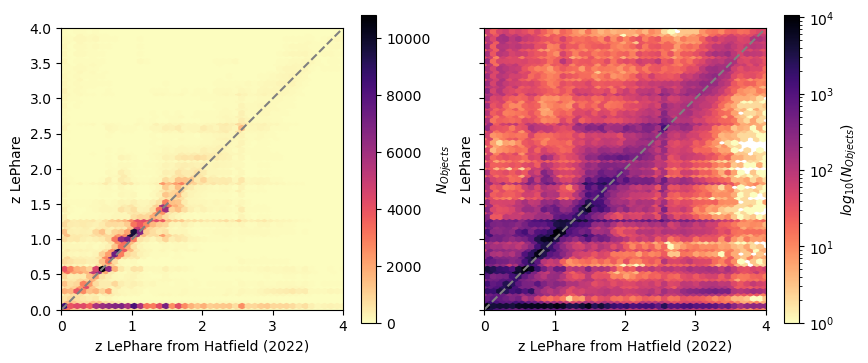

In [23]:
orig_map=plt.cm.get_cmap('magma')
reversed_map=orig_map.reversed()

xlim=0,4
ylim=0,4

fig,(ax0,ax1)=plt.subplots(ncols=2,sharey=True,figsize=(10,4))
ax0.set_aspect('equal')
ax1.set_aspect('equal')
                           
hb=ax0.hexbin(merge['zphTemp'],merge['Z_BEST'],cmap=reversed_map)
ax0.set(xlim=xlim,ylim=ylim)

ax0.set_xlabel("z LePhare from Hatfield (2022)")
ax0.set_ylabel("z LePhare")
#ax0.set_title("z phot vs z spec")
ax0.plot([0,6],[0,6],linestyle='dashed',color='grey')
cb=fig.colorbar(hb,ax=ax0,label='$N_{Objects}$')


hb=ax1.hexbin(merge['zphTemp'],merge['Z_BEST'],bins='log',cmap=reversed_map)
ax1.set(xlim=xlim,ylim=ylim)
ax1.set_xlabel("z LePhare from Hatfield (2022)")
ax1.set_ylabel("z LePhare")
#ax1.set_title("z phot vs z spec with log colour scale")
ax1.plot([0,6],[0,6],linestyle='dashed',color='grey')
cb=fig.colorbar(hb,ax=ax1,label='$log_{10}(N_{Objects})$')


fig.savefig('./figs/LePhare_photoz_Hatfield.png', bbox_inches='tight')

In [68]:
failures=(merge['zphTemp']>0.5)&(merge['Z_BEST']<0.2)


In [69]:
for b in bands:
    print("{} detection fractions for photo-z failures: {}, not failures: {}".format(band_to_physical_filter(b),
        "%.2f" %(np.sum(merge[failures]['{}_m_base_CircularApertureFlux_6_0_flux'.format(band_to_physical_filter(b))]
                 /merge[failures]['{}_m_base_CircularApertureFlux_6_0_fluxErr'.format(band_to_physical_filter(b))] > 5)/np.sum(failures)),
        "%.2f" %(np.sum(merge[~failures]['{}_m_base_CircularApertureFlux_6_0_flux'.format(band_to_physical_filter(b))]
                 /merge[~failures]['{}_m_base_CircularApertureFlux_6_0_fluxErr'.format(band_to_physical_filter(b))] > 5)/np.sum(~failures)),
         ))

HSC_G detection fractionsfailures: 0.10, not failures: 0.55
HSC_R detection fractionsfailures: 0.10, not failures: 0.55
HSC_I detection fractionsfailures: 0.09, not failures: 0.45
HSC_Z detection fractionsfailures: 0.08, not failures: 0.41
HSC_Y detection fractionsfailures: 0.06, not failures: 0.19


/var/folders/l2/pxknhjd1029ckt57_p03cm080000gn/T/ipykernel_8803/741531536.py:3: RuntimeWarning: divide by zero encountered in true_divide
  "%.2f" %(np.sum(merge[failures]['{}_m_base_CircularApertureFlux_6_0_flux'.format(band_to_physical_filter(b))]
/var/folders/l2/pxknhjd1029ckt57_p03cm080000gn/T/ipykernel_8803/741531536.py:5: RuntimeWarning: divide by zero encountered in true_divide
  "%.2f" %(np.sum(merge[~failures]['{}_m_base_CircularApertureFlux_6_0_flux'.format(band_to_physical_filter(b))]


VIRCAM_Z detection fractionsfailures: 0.06, not failures: 0.38
VIRCAM_Y detection fractionsfailures: 0.08, not failures: 0.46
VIRCAM_J detection fractionsfailures: 0.08, not failures: 0.41
VIRCAM_H detection fractionsfailures: 0.08, not failures: 0.38
VIRCAM_Ks detection fractionsfailures: 0.07, not failures: 0.34


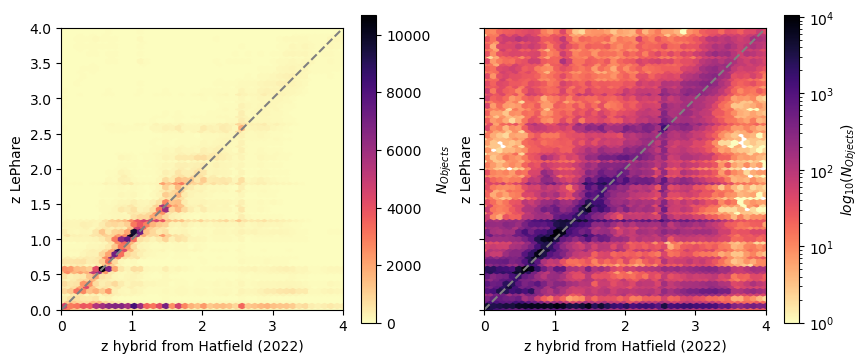

In [24]:
orig_map=plt.cm.get_cmap('magma')
reversed_map=orig_map.reversed()

xlim=0,4
ylim=0,4

fig,(ax0,ax1)=plt.subplots(ncols=2,sharey=True,figsize=(10,4))
ax0.set_aspect('equal')
ax1.set_aspect('equal')
                           
hb=ax0.hexbin(merge['zphHBbest'],merge['Z_BEST'],cmap=reversed_map)
ax0.set(xlim=xlim,ylim=ylim)

ax0.set_xlabel("z hybrid from Hatfield (2022)")
ax0.set_ylabel("z LePhare")
#ax0.set_title("z phot vs z spec")
ax0.plot([0,6],[0,6],linestyle='dashed',color='grey')
cb=fig.colorbar(hb,ax=ax0,label='$N_{Objects}$')


hb=ax1.hexbin(merge['zphHBbest'],merge['Z_BEST'],bins='log',cmap=reversed_map)
ax1.set(xlim=xlim,ylim=ylim)
ax1.set_xlabel("z hybrid from Hatfield (2022)")
ax1.set_ylabel("z LePhare")
#ax1.set_title("z phot vs z spec with log colour scale")
ax1.plot([0,6],[0,6],linestyle='dashed',color='grey')
cb=fig.colorbar(hb,ax=ax1,label='$log_{10}(N_{Objects})$')


fig.savefig('./figs/Hybrid_photoz_Hatfield.png', bbox_inches='tight')

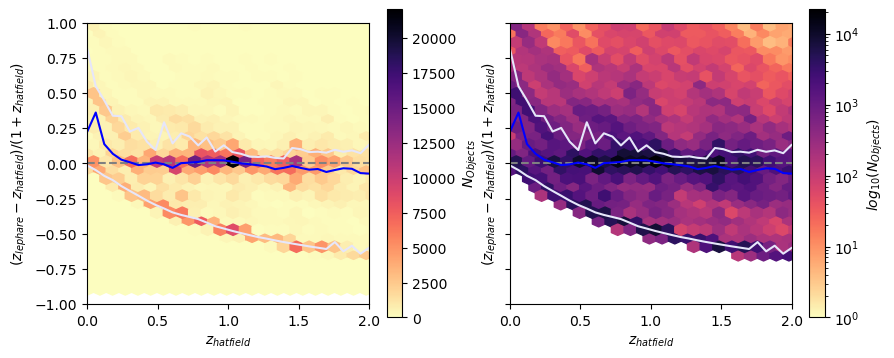

In [25]:
orig_map=plt.cm.get_cmap('magma')
reversed_map=orig_map.reversed()

xlim=[0,2]
ylim=[-1,1]

fig,(ax0,ax1)=plt.subplots(ncols=2,sharey=True,figsize=(10,4))
ax0.set_aspect('equal')
ax1.set_aspect('equal')

z1=merge['zphHBbest']
z2=merge['Z_BEST']
z1_name='z_{hatfield}'
z2_name='z_{lephare}'

bins=np.linspace(0,6,100)
delz=(z2-z1)/(1+z1)
delz_medians=[np.nanmedian(delz[(z1>bins[n]) & (z1<bins[n+1])]) for n in np.arange(len(bins[:-1]))]
delz_16s=[np.nanpercentile(delz[(z1>bins[n]) & (z1<bins[n+1])],16) for n in np.arange(len(bins[:-1]))]
delz_84s=[np.nanpercentile(delz[(z1>bins[n]) & (z1<bins[n+1])],84) for n in np.arange(len(bins[:-1]))]

hb=ax0.hexbin(z1,(z2-z1)/(1+z1),cmap=reversed_map)
ax0.set(xlim=xlim,ylim=ylim)
ax0.set_xlabel("${}$".format(z1_name))
ax0.set_ylabel("$({}-{})/(1+{})$".format(z2_name,z1_name,z1_name))
#ax0.set_title("Delta z vs z spec")
ax0.plot([0,6],[0,0],linestyle='dashed',color='grey')
ax0.plot(bins[:-1],delz_medians,color='blue')
ax0.plot(bins[:-1],delz_16s,color='lavender')
ax0.plot(bins[:-1],delz_84s,color='lavender')
cb=fig.colorbar(hb,ax=ax0,label='$N_{Objects}$')


hb=ax1.hexbin(z1,(z2-z1)/(1+z1),bins='log',cmap=reversed_map)
ax1.set(xlim=xlim,ylim=ylim)
ax1.set_xlabel("${}$".format(z1_name))
ax1.set_ylabel("$({}-{})/(1+{})$".format(z2_name,z1_name,z1_name))
#ax1.set_title("z phot vs z spec with log colour scale")
ax1.plot([0,6],[0,0],linestyle='dashed',color='grey')
ax1.plot(bins[:-1],delz_medians,color='blue')
ax1.plot(bins[:-1],delz_16s,color='lavender')
ax1.plot(bins[:-1],delz_84s,color='lavender')
cb=fig.colorbar(hb,ax=ax1,label='$log_{10}(N_{Objects})$')


fig.savefig('./figs/delz_lephare_hatfield.png', bbox_inches='tight')

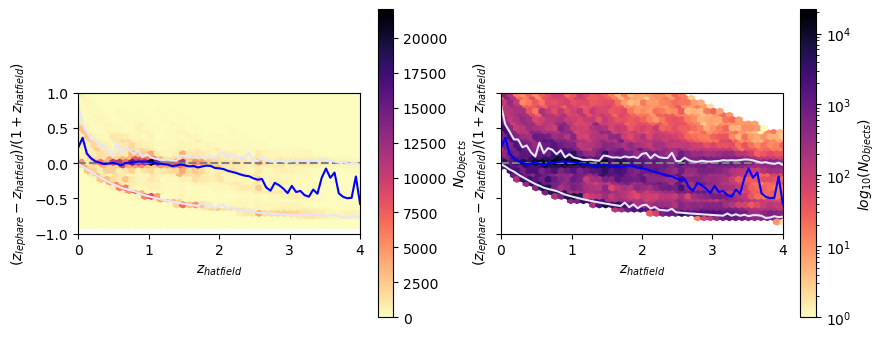

In [26]:
orig_map=plt.cm.get_cmap('magma')
reversed_map=orig_map.reversed()

xlim=[0,4]
ylim=[-1,1]

fig,(ax0,ax1)=plt.subplots(ncols=2,sharey=True,figsize=(10,4))
ax0.set_aspect('equal')
ax1.set_aspect('equal')

z1=merge['zphHBbest']
z2=merge['Z_BEST']
z1_name='z_{hatfield}'
z2_name='z_{lephare}'

bins=np.linspace(0,6,100)
delz=(z2-z1)/(1+z1)
delz_medians=[np.nanmedian(delz[(z1>bins[n]) & (z1<bins[n+1])]) for n in np.arange(len(bins[:-1]))]
delz_16s=[np.nanpercentile(delz[(z1>bins[n]) & (z1<bins[n+1])],16) for n in np.arange(len(bins[:-1]))]
delz_84s=[np.nanpercentile(delz[(z1>bins[n]) & (z1<bins[n+1])],84) for n in np.arange(len(bins[:-1]))]

hb=ax0.hexbin(z1,(z2-z1)/(1+z1),cmap=reversed_map)
ax0.set(xlim=xlim,ylim=ylim)
ax0.set_xlabel("${}$".format(z1_name))
ax0.set_ylabel("$({}-{})/(1+{})$".format(z2_name,z1_name,z1_name))
#ax0.set_title("Delta z vs z spec")
ax0.plot([0,6],[0,0],linestyle='dashed',color='grey')
ax0.plot(bins[:-1],delz_medians,color='blue')
ax0.plot(bins[:-1],delz_16s,color='lavender')
ax0.plot(bins[:-1],delz_84s,color='lavender')
cb=fig.colorbar(hb,ax=ax0,label='$N_{Objects}$')


hb=ax1.hexbin(z1,(z2-z1)/(1+z1),bins='log',cmap=reversed_map)
ax1.set(xlim=xlim,ylim=ylim)
ax1.set_xlabel("${}$".format(z1_name))
ax1.set_ylabel("$({}-{})/(1+{})$".format(z2_name,z1_name,z1_name))
#ax1.set_title("z phot vs z spec with log colour scale")
ax1.plot([0,6],[0,0],linestyle='dashed',color='grey')
ax1.plot(bins[:-1],delz_medians,color='blue')
ax1.plot(bins[:-1],delz_16s,color='lavender')
ax1.plot(bins[:-1],delz_84s,color='lavender')
cb=fig.colorbar(hb,ax=ax1,label='$log_{10}(N_{Objects})$')


fig.savefig('./figs/delz_lephare_hatfield.png', bbox_inches='tight')

In [27]:
merge[:5]

IDENT,Z_BEST,Z_BEST68_LOW,Z_BEST68_HIGH,Z_ML,CHI_BEST,MOD_BEST,EXTLAW_BEST,EBV_BEST,PDZ_BEST,SCALE_BEST,NBAND_USED,SCALE_BEST_1,NBAND_USED_1,CONTEXT,ZSPEC,Z_SEC,CHI_SEC,MOD_SEC,Z_QSO,CHI_QSO,MOD_QSO,MOD_STAR,CHI_STAR,CONTEXT_1,ZSPEC_1,id,VIRCAM_Z_m_base_ClassificationExtendedness_value,VIRCAM_Z_m_base_ClassificationExtendedness_flag,VIRCAM_Z_m_base_CircularApertureFlux_6_0_magErr,VIRCAM_Z_m_base_CircularApertureFlux_6_0_mag,VIRCAM_Z_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_Z_m_base_CircularApertureFlux_6_0_flux,VIRCAM_Z_m_base_CircularApertureFlux_6_0_flag,VIRCAM_Y_m_base_ClassificationExtendedness_value,VIRCAM_Y_m_base_ClassificationExtendedness_flag,VIRCAM_Y_m_base_CircularApertureFlux_6_0_magErr,VIRCAM_Y_m_base_CircularApertureFlux_6_0_mag,VIRCAM_Y_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_Y_m_base_CircularApertureFlux_6_0_flux,VIRCAM_Y_m_base_CircularApertureFlux_6_0_flag,VIRCAM_Ks_m_merge_peak_sky,VIRCAM_Ks_m_detect_isTractInner,VIRCAM_Ks_m_detect_isPrimary,VIRCAM_Ks_m_detect_isPatchInner,VIRCAM_Ks_m_deblend_nChild,VIRCAM_Ks_m_coord_ra,VIRCAM_Ks_m_coord_dec,VIRCAM_Ks_m_base_ClassificationExtendedness_value,VIRCAM_Ks_m_base_ClassificationExtendedness_flag,VIRCAM_Ks_m_base_CircularApertureFlux_6_0_magErr,VIRCAM_Ks_m_base_CircularApertureFlux_6_0_mag,VIRCAM_Ks_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_Ks_m_base_CircularApertureFlux_6_0_flux,VIRCAM_Ks_m_base_CircularApertureFlux_6_0_flag,VIRCAM_J_m_base_ClassificationExtendedness_value,VIRCAM_J_m_base_ClassificationExtendedness_flag,VIRCAM_J_m_base_CircularApertureFlux_6_0_magErr,VIRCAM_J_m_base_CircularApertureFlux_6_0_mag,VIRCAM_J_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_J_m_base_CircularApertureFlux_6_0_flux,VIRCAM_J_m_base_CircularApertureFlux_6_0_flag,VIRCAM_H_m_base_ClassificationExtendedness_value,VIRCAM_H_m_base_ClassificationExtendedness_flag,VIRCAM_H_m_base_CircularApertureFlux_6_0_magErr,VIRCAM_H_m_base_CircularApertureFlux_6_0_mag,VIRCAM_H_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_H_m_base_CircularApertureFlux_6_0_flux,VIRCAM_H_m_base_CircularApertureFlux_6_0_flag,HSC_Z_m_base_ClassificationExtendedness_value,HSC_Z_m_base_ClassificationExtendedness_flag,HSC_Z_m_base_CircularApertureFlux_6_0_magErr,HSC_Z_m_base_CircularApertureFlux_6_0_mag,HSC_Z_m_base_CircularApertureFlux_6_0_fluxErr,HSC_Z_m_base_CircularApertureFlux_6_0_flux,HSC_Z_m_base_CircularApertureFlux_6_0_flag,HSC_R_m_coord_ra,HSC_R_m_coord_dec,HSC_R_m_base_ClassificationExtendedness_value,HSC_R_m_base_ClassificationExtendedness_flag,HSC_R_m_base_CircularApertureFlux_6_0_magErr,HSC_R_m_base_CircularApertureFlux_6_0_mag,HSC_R_m_base_CircularApertureFlux_6_0_fluxErr,HSC_R_m_base_CircularApertureFlux_6_0_flux,HSC_R_m_base_CircularApertureFlux_6_0_flag,HSC_G_m_base_ClassificationExtendedness_value,HSC_G_m_base_ClassificationExtendedness_flag,HSC_G_m_base_CircularApertureFlux_6_0_magErr,HSC_G_m_base_CircularApertureFlux_6_0_mag,HSC_G_m_base_CircularApertureFlux_6_0_fluxErr,HSC_G_m_base_CircularApertureFlux_6_0_flux,HSC_G_m_base_CircularApertureFlux_6_0_flag,HSC_Y_m_base_ClassificationExtendedness_value,HSC_Y_m_base_ClassificationExtendedness_flag,HSC_Y_m_base_CircularApertureFlux_6_0_magErr,HSC_Y_m_base_CircularApertureFlux_6_0_mag,HSC_Y_m_base_CircularApertureFlux_6_0_fluxErr,HSC_Y_m_base_CircularApertureFlux_6_0_flux,HSC_Y_m_base_CircularApertureFlux_6_0_flag,HSC_I_m_base_ClassificationExtendedness_value,HSC_I_m_base_ClassificationExtendedness_flag,HSC_I_m_base_CircularApertureFlux_6_0_magErr,HSC_I_m_base_CircularApertureFlux_6_0_mag,HSC_I_m_base_CircularApertureFlux_6_0_fluxErr,HSC_I_m_base_CircularApertureFlux_6_0_flux,HSC_I_m_base_CircularApertureFlux_6_0_flag,ra,dec,flag_merged,RAdeg,DEdeg,zphMLbest,e_zphMLbest,zphTemp,e_zphTemp,zphHBbest,e_zphHBbest,Flag
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,mag,nJy,nJy,,,,mag,mag,nJy,nJy,,,,,,,deg,deg,,,mag,mag,nJy,nJy,,,,mag,mag,nJy,nJy,,,,mag,mag,nJy,nJy,,,,mag,mag,nJy,nJy,,deg,deg,,,mag,mag,nJy,nJy,,,,mag,mag,nJy,nJy,,,,mag,mag,nJy,nJy,,,,mag,ma

In [28]:
np.sum(merge['VIRCAM_Ks_m_base_CircularApertureFlux_6_0_flux']/merge['VIRCAM_Ks_m_base_CircularApertureFlux_6_0_fluxErr'] > 5)

1823609

## Masked plots

There will be many objects with missing bands in these plots so lets look at objects detected in all or a subset of bands to produce a cleaner sample.

In [36]:

mask_all_bands=np.full(len(merge),True)
mask_gK=np.full(len(merge),True)
for b in bands:
    physical_filter='HSC_{}'.format(b.upper())
    if b.isupper():
        physical_filter=physical_filter.replace('HSC','VIRCAM')
    physical_filter=physical_filter.replace('_K','_Ks')
    detected=(
        merge['{}_m_base_CircularApertureFlux_6_0_flux'.format(physical_filter)]
        /merge['{}_m_base_CircularApertureFlux_6_0_fluxErr'.format(physical_filter)]
        >5)
    mask_all_bands&=detected
    if b in ('g','K'):
        mask_gK&=detected
        
len(merge),np.sum(mask_all_bands),np.sum(mask_gK)


/var/folders/l2/pxknhjd1029ckt57_p03cm080000gn/T/ipykernel_8803/2918415196.py:10: RuntimeWarning: divide by zero encountered in true_divide
  merge['{}_m_base_CircularApertureFlux_6_0_flux'.format(physical_filter)]


(5466978, 404609, 1490141)

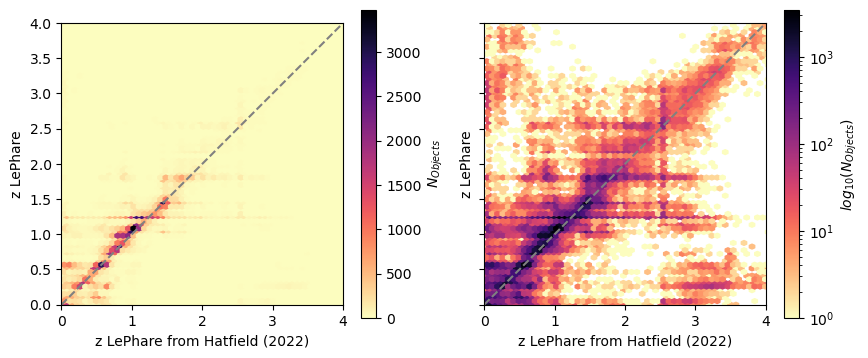

In [115]:
orig_map=plt.cm.get_cmap('magma')
reversed_map=orig_map.reversed()

xlim=0,4
ylim=0,4

fig,(ax0,ax1)=plt.subplots(ncols=2,sharey=True,figsize=(10,4))
ax0.set_aspect('equal')
ax1.set_aspect('equal')
                           
hb=ax0.hexbin(merge['zphTemp'][mask_all_bands],merge['Z_BEST'][mask_all_bands],cmap=reversed_map)
ax0.set(xlim=xlim,ylim=ylim)

ax0.set_xlabel("z LePhare from Hatfield (2022)")
ax0.set_ylabel("z LePhare")
#ax0.set_title("z phot vs z spec")
ax0.plot([0,6],[0,6],linestyle='dashed',color='grey')
cb=fig.colorbar(hb,ax=ax0,label='$N_{Objects}$')


hb=ax1.hexbin(merge['zphTemp'][mask_all_bands],merge['Z_BEST'][mask_all_bands],bins='log',cmap=reversed_map)
ax1.set(xlim=xlim,ylim=ylim)
ax1.set_xlabel("z LePhare from Hatfield (2022)")
ax1.set_ylabel("z LePhare")
#ax1.set_title("z phot vs z spec with log colour scale")
ax1.plot([0,6],[0,6],linestyle='dashed',color='grey')
cb=fig.colorbar(hb,ax=ax1,label='$log_{10}(N_{Objects})$')


fig.savefig('./figs/LePhare_photoz_Hatfield_masked.png', bbox_inches='tight')
fig.savefig('./figs/LePhare_photoz_Hatfield_masked.pdf', bbox_inches='tight')

/Users/raphaelshirley/Documents/github/lsst_stack_2022_38/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-1.0.0/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/raphaelshirley/Documents/github/lsst_stack_2022_38/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-1.0.0/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1372: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


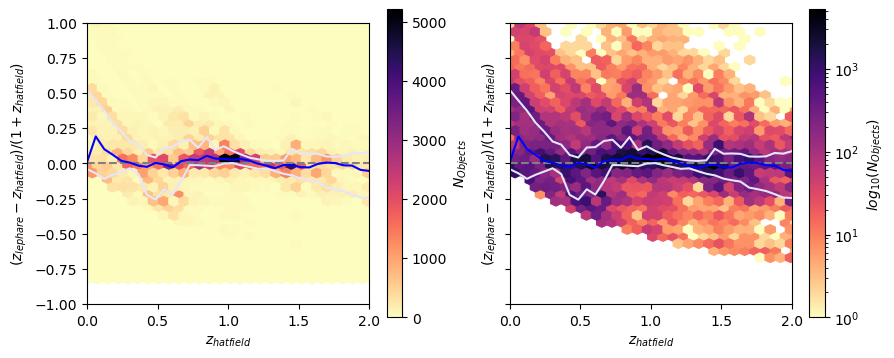

In [114]:
orig_map=plt.cm.get_cmap('magma')
reversed_map=orig_map.reversed()

xlim=[0,2]
ylim=[-1,1]

fig,(ax0,ax1)=plt.subplots(ncols=2,sharey=True,figsize=(10,4))
ax0.set_aspect('equal')
ax1.set_aspect('equal')

z1=merge['zphHBbest'][mask_all_bands]
z2=merge['Z_BEST'][mask_all_bands]
z1_name='z_{hatfield}'
z2_name='z_{lephare}'

bins=np.linspace(0,6,100)
delz=(z2-z1)/(1+z1)
delz_medians=[np.nanmedian(delz[(z1>bins[n]) & (z1<bins[n+1])]) for n in np.arange(len(bins[:-1]))]
delz_16s=[np.nanpercentile(delz[(z1>bins[n]) & (z1<bins[n+1])],16) for n in np.arange(len(bins[:-1]))]
delz_84s=[np.nanpercentile(delz[(z1>bins[n]) & (z1<bins[n+1])],84) for n in np.arange(len(bins[:-1]))]

hb=ax0.hexbin(z1,(z2-z1)/(1+z1),cmap=reversed_map)
ax0.set(xlim=xlim,ylim=ylim)
ax0.set_xlabel("${}$".format(z1_name))
ax0.set_ylabel("$({}-{})/(1+{})$".format(z2_name,z1_name,z1_name))
#ax0.set_title("Delta z vs z spec")
ax0.plot([0,6],[0,0],linestyle='dashed',color='grey')
ax0.plot(bins[:-1],delz_medians,color='blue')
ax0.plot(bins[:-1],delz_16s,color='lavender')
ax0.plot(bins[:-1],delz_84s,color='lavender')
cb=fig.colorbar(hb,ax=ax0,label='$N_{Objects}$')


hb=ax1.hexbin(z1,(z2-z1)/(1+z1),bins='log',cmap=reversed_map)
ax1.set(xlim=xlim,ylim=ylim)
ax1.set_xlabel("${}$".format(z1_name))
ax1.set_ylabel("$({}-{})/(1+{})$".format(z2_name,z1_name,z1_name))
#ax1.set_title("z phot vs z spec with log colour scale")
ax1.plot([0,6],[0,0],linestyle='dashed',color='grey')
ax1.plot(bins[:-1],delz_medians,color='blue')
ax1.plot(bins[:-1],delz_16s,color='lavender')
ax1.plot(bins[:-1],delz_84s,color='lavender')
cb=fig.colorbar(hb,ax=ax1,label='$log_{10}(N_{Objects})$')


fig.savefig('./figs/delz_lephare_hatfield_masked.png', bbox_inches='tight')
fig.savefig('./figs/delz_lephare_hatfield_masked.pdf', bbox_inches='tight')

In [43]:
combinations?

Init signature: combinations(iterable, r)
Docstring:     
Return successive r-length combinations of elements in the iterable.

combinations(range(4), 3) --> (0,1,2), (0,1,3), (0,2,3), (1,2,3)
Type:           type
Subclasses:     


In [48]:
def count_detections(table,bands):
    """Return the number of objects that have snr>5 for only the bands given"""
    mask=np.full(len(merge),True)
    for b in bands:
        physical_filter='HSC_{}'.format(b.upper())
        if b.isupper():
            physical_filter=physical_filter.replace('HSC','VIRCAM')
        physical_filter=physical_filter.replace('_K','_Ks')
        detected=(
            merge['{}_m_base_CircularApertureFlux_6_0_flux'.format(physical_filter)]
            /merge['{}_m_base_CircularApertureFlux_6_0_fluxErr'.format(physical_filter)]
            >5)
        mask&=detected
    return mask

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [91]:
# det_summaries=Table()
# n=0
# for i in np.arange(1,len(bands)+1):
#     for c in combinations(bands, i):
#         print(c)
#         n+=1
# print(n)
merge['detections']=np.full(len(merge),'',dtype='<U16')
merge['hsc_det_n']=np.full(len(merge),0)
merge['vircam_det_n']=np.full(len(merge),0)
for b in bands:
    physical_filter=band_to_physical_filter(b)
    detected=(
            merge['{}_m_base_CircularApertureFlux_6_0_flux'.format(physical_filter)]
            /merge['{}_m_base_CircularApertureFlux_6_0_fluxErr'.format(physical_filter)]
            >5)
    print("physical filter {}: {} detected out of {}".format(physical_filter, np.sum(detected),len(merge)))
    merge['detections'][detected]=[d+b for d in merge['detections'][detected]]
    if 'HSC' in physical_filter:
        merge['hsc_det_n'][detected]=merge[detected]['hsc_det_n']+1
    if 'VIRCAM' in physical_filter:
        merge['vircam_det_n'][detected]=merge[detected]['vircam_det_n']+1

physical filter HSC_G: 2972088 detected out of 5466978
physical filter HSC_R: 2972715 detected out of 5466978
physical filter HSC_I: 2432217 detected out of 5466978
physical filter HSC_Z: 2217601 detected out of 5466978
physical filter HSC_Y: 1048501 detected out of 5466978


/var/folders/l2/pxknhjd1029ckt57_p03cm080000gn/T/ipykernel_8803/3844673888.py:14: RuntimeWarning: divide by zero encountered in true_divide
  merge['{}_m_base_CircularApertureFlux_6_0_flux'.format(physical_filter)]


physical filter VIRCAM_Z: 2018974 detected out of 5466978
physical filter VIRCAM_Y: 2482594 detected out of 5466978
physical filter VIRCAM_J: 2223765 detected out of 5466978
physical filter VIRCAM_H: 2046195 detected out of 5466978
physical filter VIRCAM_Ks: 1823609 detected out of 5466978


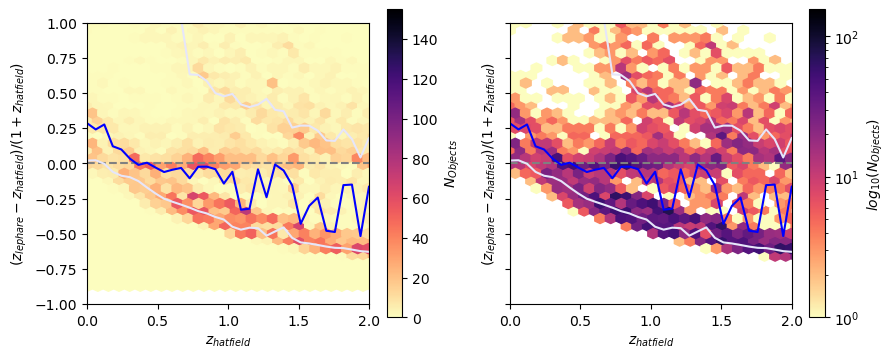

In [92]:
orig_map=plt.cm.get_cmap('magma')
reversed_map=orig_map.reversed()

xlim=[0,2]
ylim=[-1,1]

fig,(ax0,ax1)=plt.subplots(ncols=2,sharey=True,figsize=(10,4))
ax0.set_aspect('equal')
ax1.set_aspect('equal')

m=(merge['hsc_det_n']>=2) &(merge['vircam_det_n']==0)
z1=merge['zphHBbest'][m]
z2=merge['Z_BEST'][m]
z1_name='z_{hatfield}'
z2_name='z_{lephare}'

bins=np.linspace(0,6,100)
delz=(z2-z1)/(1+z1)
delz_medians=[np.nanmedian(delz[(z1>bins[n]) & (z1<bins[n+1])]) for n in np.arange(len(bins[:-1]))]
delz_16s=[np.nanpercentile(delz[(z1>bins[n]) & (z1<bins[n+1])],16) for n in np.arange(len(bins[:-1]))]
delz_84s=[np.nanpercentile(delz[(z1>bins[n]) & (z1<bins[n+1])],84) for n in np.arange(len(bins[:-1]))]

hb=ax0.hexbin(z1,(z2-z1)/(1+z1),cmap=reversed_map)
ax0.set(xlim=xlim,ylim=ylim)
ax0.set_xlabel("${}$".format(z1_name))
ax0.set_ylabel("$({}-{})/(1+{})$".format(z2_name,z1_name,z1_name))
#ax0.set_title("Delta z vs z spec")
ax0.plot([0,6],[0,0],linestyle='dashed',color='grey')
ax0.plot(bins[:-1],delz_medians,color='blue')
ax0.plot(bins[:-1],delz_16s,color='lavender')
ax0.plot(bins[:-1],delz_84s,color='lavender')
cb=fig.colorbar(hb,ax=ax0,label='$N_{Objects}$')


hb=ax1.hexbin(z1,(z2-z1)/(1+z1),bins='log',cmap=reversed_map)
ax1.set(xlim=xlim,ylim=ylim)
ax1.set_xlabel("${}$".format(z1_name))
ax1.set_ylabel("$({}-{})/(1+{})$".format(z2_name,z1_name,z1_name))
#ax1.set_title("z phot vs z spec with log colour scale")
ax1.plot([0,6],[0,0],linestyle='dashed',color='grey')
ax1.plot(bins[:-1],delz_medians,color='blue')
ax1.plot(bins[:-1],delz_16s,color='lavender')
ax1.plot(bins[:-1],delz_84s,color='lavender')
cb=fig.colorbar(hb,ax=ax1,label='$log_{10}(N_{Objects})$')


fig.savefig('./figs/delz_lephare_hatfield_masked.png', bbox_inches='tight')

In [93]:
merge[:5]

IDENT,Z_BEST,Z_BEST68_LOW,Z_BEST68_HIGH,Z_ML,CHI_BEST,MOD_BEST,EXTLAW_BEST,EBV_BEST,PDZ_BEST,SCALE_BEST,NBAND_USED,SCALE_BEST_1,NBAND_USED_1,CONTEXT,ZSPEC,Z_SEC,CHI_SEC,MOD_SEC,Z_QSO,CHI_QSO,MOD_QSO,MOD_STAR,CHI_STAR,CONTEXT_1,ZSPEC_1,id,VIRCAM_Z_m_base_ClassificationExtendedness_value,VIRCAM_Z_m_base_ClassificationExtendedness_flag,VIRCAM_Z_m_base_CircularApertureFlux_6_0_magErr,VIRCAM_Z_m_base_CircularApertureFlux_6_0_mag,VIRCAM_Z_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_Z_m_base_CircularApertureFlux_6_0_flux,VIRCAM_Z_m_base_CircularApertureFlux_6_0_flag,VIRCAM_Y_m_base_ClassificationExtendedness_value,VIRCAM_Y_m_base_ClassificationExtendedness_flag,VIRCAM_Y_m_base_CircularApertureFlux_6_0_magErr,VIRCAM_Y_m_base_CircularApertureFlux_6_0_mag,VIRCAM_Y_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_Y_m_base_CircularApertureFlux_6_0_flux,VIRCAM_Y_m_base_CircularApertureFlux_6_0_flag,VIRCAM_Ks_m_merge_peak_sky,VIRCAM_Ks_m_detect_isTractInner,VIRCAM_Ks_m_detect_isPrimary,VIRCAM_Ks_m_detect_isPatchInner,VIRCAM_Ks_m_deblend_nChild,VIRCAM_Ks_m_coord_ra,VIRCAM_Ks_m_coord_dec,VIRCAM_Ks_m_base_ClassificationExtendedness_value,VIRCAM_Ks_m_base_ClassificationExtendedness_flag,VIRCAM_Ks_m_base_CircularApertureFlux_6_0_magErr,VIRCAM_Ks_m_base_CircularApertureFlux_6_0_mag,VIRCAM_Ks_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_Ks_m_base_CircularApertureFlux_6_0_flux,VIRCAM_Ks_m_base_CircularApertureFlux_6_0_flag,VIRCAM_J_m_base_ClassificationExtendedness_value,VIRCAM_J_m_base_ClassificationExtendedness_flag,VIRCAM_J_m_base_CircularApertureFlux_6_0_magErr,VIRCAM_J_m_base_CircularApertureFlux_6_0_mag,VIRCAM_J_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_J_m_base_CircularApertureFlux_6_0_flux,VIRCAM_J_m_base_CircularApertureFlux_6_0_flag,VIRCAM_H_m_base_ClassificationExtendedness_value,VIRCAM_H_m_base_ClassificationExtendedness_flag,VIRCAM_H_m_base_CircularApertureFlux_6_0_magErr,VIRCAM_H_m_base_CircularApertureFlux_6_0_mag,VIRCAM_H_m_base_CircularApertureFlux_6_0_fluxErr,VIRCAM_H_m_base_CircularApertureFlux_6_0_flux,VIRCAM_H_m_base_CircularApertureFlux_6_0_flag,HSC_Z_m_base_ClassificationExtendedness_value,HSC_Z_m_base_ClassificationExtendedness_flag,HSC_Z_m_base_CircularApertureFlux_6_0_magErr,HSC_Z_m_base_CircularApertureFlux_6_0_mag,HSC_Z_m_base_CircularApertureFlux_6_0_fluxErr,HSC_Z_m_base_CircularApertureFlux_6_0_flux,HSC_Z_m_base_CircularApertureFlux_6_0_flag,HSC_R_m_coord_ra,HSC_R_m_coord_dec,HSC_R_m_base_ClassificationExtendedness_value,HSC_R_m_base_ClassificationExtendedness_flag,HSC_R_m_base_CircularApertureFlux_6_0_magErr,HSC_R_m_base_CircularApertureFlux_6_0_mag,HSC_R_m_base_CircularApertureFlux_6_0_fluxErr,HSC_R_m_base_CircularApertureFlux_6_0_flux,HSC_R_m_base_CircularApertureFlux_6_0_flag,HSC_G_m_base_ClassificationExtendedness_value,HSC_G_m_base_ClassificationExtendedness_flag,HSC_G_m_base_CircularApertureFlux_6_0_magErr,HSC_G_m_base_CircularApertureFlux_6_0_mag,HSC_G_m_base_CircularApertureFlux_6_0_fluxErr,HSC_G_m_base_CircularApertureFlux_6_0_flux,HSC_G_m_base_CircularApertureFlux_6_0_flag,HSC_Y_m_base_ClassificationExtendedness_value,HSC_Y_m_base_ClassificationExtendedness_flag,HSC_Y_m_base_CircularApertureFlux_6_0_magErr,HSC_Y_m_base_CircularApertureFlux_6_0_mag,HSC_Y_m_base_CircularApertureFlux_6_0_fluxErr,HSC_Y_m_base_CircularApertureFlux_6_0_flux,HSC_Y_m_base_CircularApertureFlux_6_0_flag,HSC_I_m_base_ClassificationExtendedness_value,HSC_I_m_base_ClassificationExtendedness_flag,HSC_I_m_base_CircularApertureFlux_6_0_magErr,HSC_I_m_base_CircularApertureFlux_6_0_mag,HSC_I_m_base_CircularApertureFlux_6_0_fluxErr,HSC_I_m_base_CircularApertureFlux_6_0_flux,HSC_I_m_base_CircularApertureFlux_6_0_flag,ra,dec,flag_merged,RAdeg,DEdeg,zphMLbest,e_zphMLbest,zphTemp,e_zphTemp,zphHBbest,e_zphHBbest,Flag,detections,hsc_det_n,vircam_det_n
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,mag,nJy,nJy,,,,mag,mag,nJy,nJy,,,,,,,deg,deg,,,mag,mag,nJy,nJy,,,,mag,mag,nJy,nJy,,,,mag,mag,nJy,nJy,,,,mag,mag,nJy,nJy,,deg,deg,,,mag,mag,nJy,nJy,,,,mag,mag,nJ

In [96]:
(len(merge),
 np.sum(merge['hsc_det_n']>=2),
 np.sum(merge['vircam_det_n']==0),
 np.sum((merge['hsc_det_n']>=2)&(merge['vircam_det_n']==0)))




(5466978, 3056666, 2328921, 486012)

In [97]:
np.sum((merge['hsc_det_n']==0)&(merge['vircam_det_n']>=2))

165859

In [111]:
from astropy.io import fits
schema='../../dmu4/dmu4_Example/data/videoStep3a/20230308T155148Z/deepCoadd_det_schema/deepCoadd_det_schema_videoStep3a_20230308T155148Z.fits'
hdu1 = fits.open(schema)

In [110]:
hdu1.info()

Filename: ../../dmu4/dmu4_Example/data/videoStep3a/20230308T155148Z/deepCoadd_det_schema/deepCoadd_det_schema_videoStep3a_20230308T155148Z.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1                1 BinTableHDU     33   0R x 5C   [1K, 1D, 1D, 1K, 1J]   
  2  ARCHIVE_INDEX    1 BinTableHDU     41   0R x 7C   [1J, 1J, 1J, 1J, 1J, 64A, 64A]   


In [113]:
Table.read(schema,hdu=2)

id,cat.archive,cat.persistable,row0,nrows,name,module
int32,int32,int32,int32,int32,bytes64,bytes64
